In [1]:
import sys
sys.path.insert(0, '../../../')

import pandas as pd
from preprocess import Audio_Processor
from data_utils import balanced_supersample, balanced_subsample
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import numpy as np
from data_utils import enumerate_strings
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
path_to_db='../../../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 1,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [ ]:
dataset = dataset[dataset.h_target == 0].reset_index()
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        feature_bag=False,
                        folds=5
                       )
df.head()

In [6]:
train = ps.bag_of_features(df[df.fold != 1].reset_index())
train.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,81.355627,60.950895,35.026463,48.047609,53.739915,42.014673,48.515288,36.766431,53.463175,52.233060,...,0.425719,0.243835,12.205491,13.338520,5.419358,15.416913,3.034387,0,14,5
1,82.090071,66.576588,44.457472,43.406209,51.750090,33.061378,44.813918,43.999085,45.518410,41.850523,...,-0.012500,0.257141,9.483506,12.958784,4.558367,15.372567,2.792519,0,14,5
2,84.208982,62.966970,46.823424,37.631471,47.758099,42.029236,54.039877,44.406314,43.668848,47.363946,...,0.079334,0.517184,12.201532,11.095703,4.802391,15.916300,3.168262,0,14,5
3,70.073610,82.465856,47.496273,57.899457,57.234505,36.226570,59.486281,44.904293,37.335008,41.632832,...,0.297949,0.001637,9.933414,15.130064,4.932393,18.708356,3.396824,0,14,5
4,64.759162,101.448273,69.353902,61.032527,48.199999,48.181578,57.047702,46.993057,49.225614,39.971573,...,0.186153,0.195547,15.884816,10.161794,5.320202,13.979928,3.583472,0,14,5


In [7]:
test = ps.bag_of_features(df[df.fold == 1].reset_index())
test.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,52.009557,4.327045,5.696827,6.522973,3.426770,9.314700,8.897445,1.613144,3.654356,6.125930,...,-0.430331,0.430331,29.442891,33.986595,7.463287,129.495423,54.772801,0,0,1
1,88.404377,82.645071,55.548627,51.936489,32.090942,23.103625,23.082517,18.536499,16.418501,15.469806,...,0.475820,-0.102448,15.695233,20.199985,3.943083,20.152053,1.728330,0,0,1
2,86.987377,78.083572,51.433488,51.561430,33.107803,31.318922,21.869279,15.681414,22.181496,16.827397,...,0.254841,0.158864,14.345672,19.755847,3.758124,17.172734,1.683485,0,0,1
3,80.670230,68.750011,19.582458,23.847321,18.158782,20.392203,9.204180,11.268402,12.634953,12.072391,...,0.278538,0.105655,25.330133,34.365584,4.991139,27.321271,10.232799,0,0,1
4,50.979607,55.446231,49.674923,43.734331,42.294420,39.404698,35.739370,24.890729,33.219477,32.111632,...,0.271809,0.041270,7.369319,14.328015,3.477223,14.190838,3.021857,1,22,1


In [8]:
train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train['h_target']
train_yy = train['target']
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test['h_target']
test_yy = test['target']

# Training

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import scipy

params = {
    'classify__n_estimators': range(5,100,1),
    'classify__criterion': ('gini', 'entropy'),
    'classify__max_depth': range(len(df.columns), 5 * len(df.columns)),
    'classify__max_features': ('log2', 'auto', None),
    'classify__oob_score': (True, False),
    'classify__warm_start': (True, False)
}

clf = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feat_sel', SelectKBest(k=80, score_func=chi2)),
    ('feat_red', PCA(n_components=50)),
    ('classify', RandomForestClassifier(n_jobs=10, random_state=42))
])

randsrc = RandomizedSearchCV(
                clf,
                scoring=['accuracy', 'f1_weighted', 'recall_weighted', 'precision_weighted'], 
                cv=10,
                refit=False,
                param_distributions = params,
                verbose=2,
                n_jobs=10,
                n_iter=100
)

randsrc.fit(train_X[train_y == 0], train_yy[train_y == 0])

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  6.5min
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed: 11.7min
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed: 19.8min
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed: 30.0min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat_sel', SelectKBest(k=80, score_func=<function chi2 at 0x7fb97de92378>)), ('feat_red', PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', RandomFor...tors='warn', n_jobs=10,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=10,
          param_distributions={'classify__criterion': ('gini', 'entropy'), 'classify__max_features': ('log2', 'auto', None), 'classify__max_depth': range(4, 20), 'classify__n_estimators': range(5, 100), 'classify__warm_start': (True, False), 'classify__oob_score': (True, False)},
          pre_dispatch='2*n_jobs', random_state=None, refit=False,
          return_train_score='warn',
          scoring=['accuracy', 'f1_weight

In [19]:
results = pd.DataFrame(randsrc.cv_results_)
results.head()

,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_f1_weighted,mean_test_precision_weighted,mean_test_recall_weighted,mean_train_accuracy,mean_train_f1_weighted,mean_train_precision_weighted,mean_train_recall_weighted,...,std_fit_time,std_score_time,std_test_accuracy,std_test_f1_weighted,std_test_precision_weighted,std_test_recall_weighted,std_train_accuracy,std_train_f1_weighted,std_train_precision_weighted,std_train_recall_weighted
0,8.760246,0.979276,0.260065,0.204483,0.225325,0.260065,0.322622,0.264624,0.417012,0.322622,...,0.488212,0.127257,0.030446,0.024432,0.047532,0.030446,0.005901,0.007071,0.028734,0.005901
1,16.971850,0.853435,0.339115,0.317262,0.322443,0.339115,1.000000,1.000000,1.000000,1.000000,...,0.463614,0.112041,0.030918,0.028663,0.030796,0.030918,0.000000,0.000000,0.000000,0.000000
2,53.343406,0.843025,0.311469,0.289011,0.303213,0.311469,0.634327,0.632651,0.669191,0.634327,...,1.595073,0.081768,0.029930,0.025499,0.031268,0.029930,0.006912,0.006452,0.006015,0.006912
3,10.279873,0.972381,0.321350,0.283999,0.316102,0.321350,0.647573,0.639101,0.696852,0.647573,...,0.848563,0.115411,0.034919,0.032329,0.043992,0.034919,0.010529,0.011018,0.009891,0.010529
4,43.269018,0.905081,0.325029,0.311298,0.315282,0.325029,0.999930,0.999930,0.999930,0.999930,...,1.501317,0.166695,0.028603,0.024985,0.025692,0.028603,0.000140,0.000140,0.000139,0.000140


In [20]:
top = results.sort_values(['mean_test_accuracy', 'mean_fit_time'], ascending=[False, True]).iloc[0]

In [21]:
top.params

{'classify__criterion': 'gini',
 'classify__max_depth': 17,
 'classify__max_features': 'log2',
 'classify__n_estimators': 89,
 'classify__oob_score': True,
 'classify__warm_start': True}

In [22]:
clf.set_params(**top.params)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat_sel', SelectKBest(k=80, score_func=<function chi2 at 0x7fb97de92378>)), ('feat_red', PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', RandomFor...estimators=89, n_jobs=10,
            oob_score=True, random_state=42, verbose=0, warm_start=True))])

# Testing Optimal Classifier

### Training

In [23]:
clf.fit(train_X[train_y == 0], train_yy[train_y == 0])

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat_sel', SelectKBest(k=80, score_func=<function chi2 at 0x7fb97de92378>)), ('feat_red', PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', RandomFor...estimators=89, n_jobs=10,
            oob_score=True, random_state=42, verbose=0, warm_start=True))])

0.2980877390326209
Confusion matrix, without normalization
[[91  4  4  4 26 11 30  2  4  2  0  0  3 14  5 15  6  3]
 [ 5 23  1  9  9 11 10  4  2  1  1  2 16 16  0  3  1  8]
 [ 2  1 39  3 10  2 22  2 16  7 13 21 14  1 12  1  1 12]
 [18  1  0 67  2 12  4 21 25  2  1  0  3 10  5  2  0 22]
 [25  0  6  0 73  1  4  0  4  4  3  7  2  0  2  0  0  2]
 [ 3  4  0  7 11 32  6 11 15  2  8  2  8  3  0  2  2  3]
 [ 1  1  2  1 17  5 23  8  9  4  6  7 10  1  1  1  6  2]
 [ 3  0  2  5  6  5  3 40 29  5 37  5 23  1  4  3  0 23]
 [ 0  1  1 22  2  6  1  5 70  8 10  5 14  0  2  0  5 19]
 [ 0  0  3  3  3  4  5  7 26 46 28 23 11  0  2  0  0  6]
 [ 0  0  0  0 15  1 22  1  2  0 12  3  0  0  0  0  1  0]
 [ 0  0  3  1  8  3  4  5  5  5 84 56  5  0  5  1  3  2]
 [ 1  3  2  1  7  9 19  4  9  3  1  8 45  3 12  1 10  7]
 [ 1  1  1  0  1  4  4  4  3  0  5  1  3  8  2  2  0  9]
 [ 0  1  1 14  1  5  6  2 14  3  1  0  6  1 53  3  1 29]
 [ 7  2 14  3  2  4 10  0  2  1  0  2  7 21 16 24  9  8]
 [ 2  7  9  7 17  9 55  6  3 

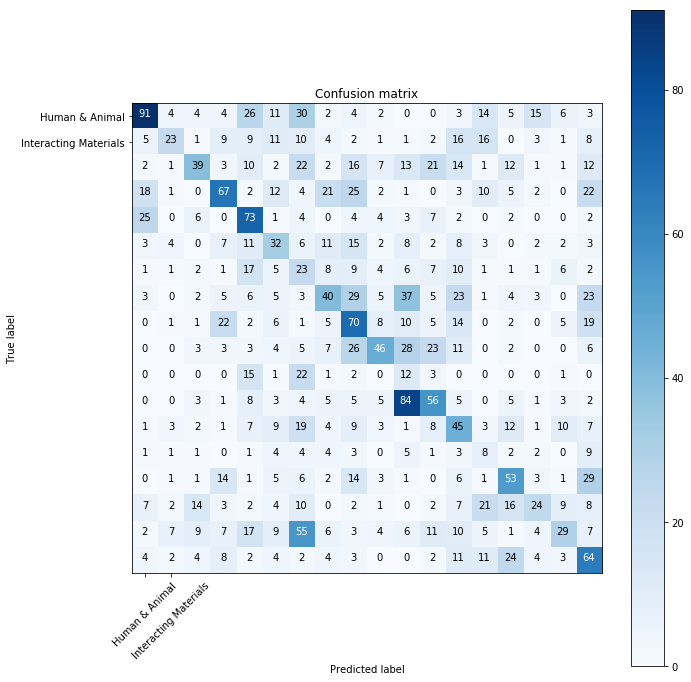

In [24]:
pred = clf.predict(test_X[test_y == 0])
print(metrics.accuracy_score(test_yy[test_y == 0], pred))
cm = metrics.confusion_matrix(test_yy[test_y == 0], pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

### Confidence

In [25]:
import seaborn as sns
misclassified = {
    'Predicted h_target': [],
    'Actual target': [],
    'Anim_prob': [],
    'Interact_prob': []
}

correctly_classified = {
    'Predicted h_target': [],
    'Actual target': [],
    'Anim_prob': [],
    'Interact_prob': []
}

for row, p, prob, Y in zip(all_df.iterrows(), pred, pred_prob, y):
    Y = int(Y)
    p = int(p)
    if p!=Y:
        misclassified['Actual target'].append(classes[int(row[1]['target'])])
        misclassified['Predicted h_target'].append(h_classes[p])
        misclassified['Anim_prob'].append(prob[0])
        misclassified['Interact_prob'].append(prob[1])
    else:
        correctly_classified['Actual target'].append(classes[int(row[1]['target'])])
        correctly_classified['Predicted h_target'].append(h_classes[p])
        correctly_classified['Anim_prob'].append(prob[0])
        correctly_classified['Interact_prob'].append(prob[1])

misclassified = pd.DataFrame.from_dict(misclassified)
correctly_classified = pd.DataFrame.from_dict(correctly_classified)

NameError: name 'all_df' is not defined

In [ ]:
gb_ms = misclassified.groupby('Predicted h_target')
means = gb_ms.mean()
errors = gb_ms.std()

In [ ]:
means.head()

In [ ]:
errors.head()

In [ ]:
means.min(axis=1).plot(yerr=errors, kind='bar')

In [ ]:
gb_ms = correctly_classified.groupby('Predicted h_target')
means = gb_ms.mean()
errors = gb_ms.std()

In [ ]:
means.head()

In [ ]:
errors.head()

In [ ]:
means.min(axis=1).plot(yerr=errors, kind='bar')

In [ ]:
average_prob = misclassified.groupby('Actual target').mean()
average_prob

In [ ]:
average_prob.min(axis=1).plot(kind='bar')

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(50,10))
sns.countplot(x='Actual target', hue='Predicted h_target',data=misclassified)